In [47]:
import cv2
import numpy as np
from skimage.filters import frangi, sobel
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import moment
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import KFold
from keras import metrics
from tensorflow.python.keras.callbacks import EarlyStopping

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Część na 3.0

In [0]:
def show_image(img, title="test"):
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Wczytanie zdjęcia

In [0]:
image_size = 200
#blada gałka oczna na czarnym tle
#image = cv2.imread('zdjecia/2_good.JPG') # 11.42 / 10.99

#bardziej czerwona głka oczna na czrnym tle
#image = cv2.imread('zdjecia/8_good.JPG') # 21.93 / 21.25

#duża pomarańczowa gałka oczna na czarnym tle
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R.jpg') # 51.76 / 56.1

image = cv2.resize(image, (image_size, image_size))

gray_to_find_circle = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## Wstępne przetworzenie obrazu

In [0]:
def thresh_show(image, th1):
    
    image2 = cv2.threshold(image, th1, 255, cv2.THRESH_BINARY)[1]
    #show_image(image2)
    
    return cv2.findContours(image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


def contrast_image(image, low_value, high_value):
    res = [[contrast(x, low_value, high_value) for x in y] for y in image]
    return np.array(res)


def contrast(value, low, high):
    if value < low:
        return 0
    if value > high:
        return 1
    return (value - low)/(high - low)

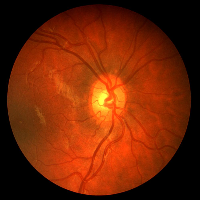

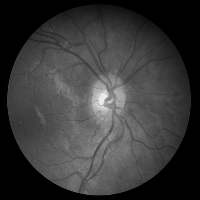

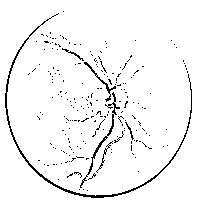

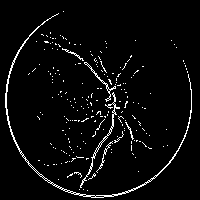

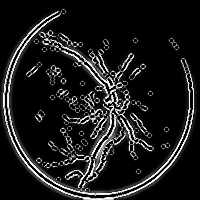

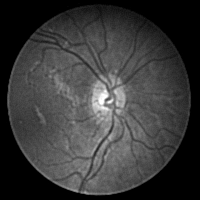

'image = cv2.filter2D(image, -1, kernel) \nimage = cv2.filter2D(image, -1, kernel) \nshow_image(image, title="filter")'

In [6]:
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R.jpg') # 51.76 / 56.1

image = cv2.resize(image, (image_size, image_size))

gray_to_find_circle = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#rozmycie
gray_to_find_circle = cv2.GaussianBlur(gray_to_find_circle, (5, 5), 0) # medianblur, guassianblur ? 
show_image(image, title="blur") 

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image, (1, 1), 0) # medianblur, guassianblur ?
show_image(image, title="blur2")

nonzero_photo = image[np.nonzero(image)]
percentiles = np.percentile(nonzero_photo,(1, 99))
image = contrast_image(image, percentiles[0], percentiles[1])

image = cv2.adaptiveThreshold((image*255).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,15) 
show_image(image, "adaptive")

image = cv2.Laplacian(image,cv2.CV_64F)
show_image(image, "sobel")

image = frangi(image) 
image = (image*255).astype(np.uint8)
show_image(image, title="frangi")

#wyostrzenie
#obraz potrzebny do odnalezienia gałki ocznej
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 
gray_to_find_circle = cv2.filter2D(gray_to_find_circle, -1, kernel) 
show_image(gray_to_find_circle, title="filter")


#obraz na którym będziemy dalej pracować
'''image = cv2.filter2D(image, -1, kernel) 
image = cv2.filter2D(image, -1, kernel) 
show_image(image, title="filter")'''

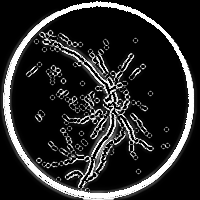

In [7]:
# szukamy gałki ocznej
contours, hierarchy = thresh_show(gray_to_find_circle, 0)

contours_approved = []
(cx, cy) , radius = (0, 0), 0
global approxx
maxArea = 0
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
    if len(approx) >= 7:
        area = cv2.contourArea(cnt)
        (cx, cy), radius = cv2.minEnclosingCircle(cnt)
        circleArea = radius * radius * np.pi
        if maxArea<area:
            contours_approved = []
            maxArea = area
            contours_approved.append(cnt)
            approxx = approx

# wiodący obraz z konturami gałki ocznej i wypełnieniem
cv2.drawContours(image, contours_approved, -1, (255, 0, 0), 3) 
show_image(image, title="wiodacy obraz z konturami galki ocznej")

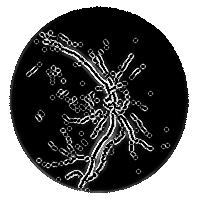

In [8]:
rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

fill_color = [255, 255, 255]
mask_value = 255 

stencil  = np.zeros(rgb.shape[:-1]).astype(np.uint8)
cv2.fillPoly(stencil, contours_approved, mask_value)

sel      = stencil != mask_value # select everything that is not mask_value
rgb[sel] = fill_color            # and fill it with fill_color

show_image(rgb, title="wiodacy obraz z konturami galki ocznej i wypelnieniem" )

## Właściwe przetworzenie obrazu

In [0]:
def nothing(x):
    pass

def trackbar_thresholds(image):
    cv2.namedWindow('myImage')

    cv2.createTrackbar('threshold1', 'myImage', 0, 255, nothing)
    cv2.createTrackbar('threshold2', 'myImage', 0, 255, nothing)

    
    image2 = image

    while(1):
        cv2.imshow('myImage', image2)
        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            break
        # get current positions of four trackbars
        th1 = cv2.getTrackbarPos('threshold1', 'myImage')
        th2 = cv2.getTrackbarPos('threshold2', 'myImage')
        # canny
        image2 = cv2.Canny(image, th1, th2)
        
    cv2.destroyAllWindows()

In [0]:
image = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

In [0]:
def threshold(img, threshpoint):
    return np.array([[1 if x >= threshpoint else 0 for x in y] for y in img])

63.896795


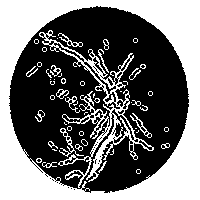

In [12]:
#trackbar_thresholds(image)

#image = cv2.Canny(image, 100, 230)
# wykrywanie krawędzi
#image = frangi(image, black_ridges=True)
image_mean = np.mean(image)

wspol = 0.7 * image_mean - 10 # 0 - 15
print(wspol)

# thresholding
ret,image2 = cv2.threshold(image,wspol, 255, cv2.THRESH_BINARY)
show_image(image2)



## Sprawdzenie

In [13]:
global odp
odp = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R_2ndHO.png')
odp = cv2.resize(odp, (image_size, image_size))
odp = cv2.cvtColor(odp, cv2.COLOR_BGR2GRAY)
ret, odp = cv2.threshold(odp,127, 255, cv2.THRESH_BINARY)
odp = cv2.bitwise_not(odp)

#show_image(odp)
max_val = image_size**2
max_val

40000

In [14]:
np.unique(odp)
#show_image(odp)

array([  0, 255], dtype=uint8)

In [0]:
# white == 255 == not vessel
# black == 0 == vessel
global TP, FP, FN, TN

# true-positve (prawdziwie dodatnie)
# naczynie uznane jako naczynie
def count_TP(actually, result):
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 0) and (res_ == 0):
            i += 1
    return i

# false-positive (fałszywie dodatnie)
# nie-naczynie uznane jako naczynie
def count_FP(actually, result):
    
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 255) and (res_ == 0):
            i += 1
    return i

# false-negative (fałszywie ujemne)
# naczynie uznane jako nie-naczynie
def count_FN(actually, result):
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 0) and (res_ == 255):
            i += 1
    return i

# true-negative (prawdziwie ujemne)
# nie-naczynie uznane jako nie-naczynie
def count_TN(actually, result):
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 255) and (res_ == 255):
            i += 1
    return i


In [16]:
TP = count_TP( np.nditer(odp), np.nditer(image2))
print("TP = " + str(TP/max_val))

TP = 0.050025


In [17]:
FP = count_FP( np.nditer(odp), np.nditer(image2))
print("FP = " + str(FP/max_val))

FP = 0.5113


In [18]:
FN = count_FN( np.nditer(odp), np.nditer(image2))
print("FN = " + str(FN/max_val))

FN = 0.010225


In [19]:
TN = count_TN( np.nditer(odp), np.nditer(image2))
print("TN = " + str(TN/max_val))

TN = 0.42845


In [20]:
def confusion_matrix():
    names = {
        'My Results' : ['Positive', 'Negative', 'Sum'],
        'Actually - Positive' : [TP, FN, TP + FN],
        'Actually - Negative' : [FP, TN, FP + TN],
        'Sum' : [TP + FP, FN + TN, TP + FP + FN + TN]
    }
    
    return pd.DataFrame(names, columns=['My Results', 'Actually - Positive', 'Actually - Negative', 'Sum' ]).set_index('My Results')

df_confusion_matrix = confusion_matrix()
df_confusion_matrix

,Actually - Positive,Actually - Negative,Sum
My Results,,,
Positive,2001,20452,22453
Negative,409,17138,17547
Sum,2410,37590,40000


In [21]:
# trafność
def count_accuracy():
    return (TP + TN)/(TP + TN + FP + FN)
count_accuracy()

0.478475

In [22]:
# czułość
def count_sensitivity():
    return TP/(TP + FN)
count_sensitivity()

0.8302904564315353

In [23]:
# swoistość
def count_specificity():
    return TN/(FP + TN)
count_specificity()

0.45591912742750734

# Część na 5.0

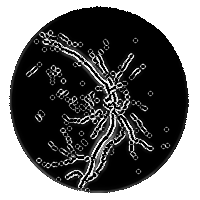

In [24]:
show_image(image)

In [70]:
column_names = ["X", "Y", "Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance", 
               "Third central moment", #"Image moment", 
                "Right value" ]

global df
df = pd.DataFrame(columns = column_names)
df

,X,Y,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment,Right value


In [0]:
def workForThisSquare(index, firstCol, firstRow):
    lastRow = firstRow + 5
    lastCol = firstCol + 5
    
    X = firstCol + 2
    Y = firstRow + 2
    PixelValue = image[X, Y]
    
    smallArray = image[firstRow:lastRow, firstCol:lastCol]
    
    MeanForSquare = np.mean(smallArray)
    MaxValueForSquare = np.max(smallArray)
    MinValueForSquare = np.min(smallArray)
    Variance = np.var(smallArray)
    ThirdCentralMoment = moment(smallArray, moment = 3)[0]
    
    RightValue = 0 if odp[X, Y] == 255 else 1
    
    
    df.loc[index] = [X, Y, PixelValue, MeanForSquare, MaxValueForSquare, 
                     MinValueForSquare, Variance, ThirdCentralMoment,RightValue]
    


In [72]:
"""last = 10

for c in range(0, last):
  for r in range(0, last):
    if((c>1) and (c<(last-2)) and (r>1) and (r<(last-2))):
      pass
    else:
      print(c, r)"""

'last = 10\n\nfor c in range(0, last):\n  for r in range(0, last):\n    if((c>1) and (c<(last-2)) and (r>1) and (r<(last-2))):\n      pass\n    else:\n      print(c, r)'

In [0]:
cols = image.shape[1]
rows = image.shape[0]

i = 0

for c in range(0, cols - 4):
    for r in range(0, rows - 4):
        workForThisSquare(i, c, r)
        i += 1
        
for c in range(0, cols):
  for r in range(0, rows):
    if((c>1) and (c<(cols-2)) and (r>1) and (r<(rows-2))):
      pass
    else:
      RightValue = 0 if odp[c, r] == 255 else 1
      df.loc[i] = [c, r, image[c, r], 255, 255, 255, 0.0, 0.0,RightValue]
      i += 1


In [74]:
df

,X,Y,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment,Right value
0,2.0,2.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
1,2.0,3.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
2,2.0,4.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
3,2.0,5.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
4,2.0,6.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
39995,199.0,195.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
39996,199.0,196.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
39997,199.0,197.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
39998,199.0,198.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0


In [0]:
# some data
df[df['X']==100].head(20)

,X,Y,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment,Right value
19208,100.0,2.0,255.0,255.0,255.0,255.0,0.00,0.0,0.0
19209,100.0,3.0,255.0,255.0,255.0,255.0,0.00,0.0,0.0
19210,100.0,4.0,255.0,244.8,255.0,0.0,2496.96,0.0,0.0
19211,100.0,5.0,255.0,193.8,255.0,0.0,11860.56,-1591812.0,0.0
19212,100.0,6.0,255.0,142.8,255.0,0.0,16022.16,-795906.0,0.0
19213,100.0,7.0,255.0,91.8,255.0,0.0,14981.76,795906.0,0.0
19214,100.0,8.0,255.0,40.8,255.0,0.0,8739.36,1591812.0,0.0
19215,100.0,9.0,255.0,0.0,0.0,0.0,0.00,0.0,0.0
19216,100.0,10.0,55.0,0.0,0.0,0.0,0.00,0.0,0.0
19217,100.0,11.0,31.0,0.0,0.0,0.0,0.00,0.0,0.0


In [78]:
X_cols = ["Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance",
               "Third central moment"]
y_col = ["Right value"]

X = df[X_cols]
y = df[y_col]

X

,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment
0,255.0,255.0,255.0,255.0,0.0,0.0
1,255.0,255.0,255.0,255.0,0.0,0.0
2,255.0,255.0,255.0,255.0,0.0,0.0
3,255.0,255.0,255.0,255.0,0.0,0.0
4,255.0,255.0,255.0,255.0,0.0,0.0
...,...,...,...,...,...,...
39995,255.0,255.0,255.0,255.0,0.0,0.0
39996,255.0,255.0,255.0,255.0,0.0,0.0
39997,255.0,255.0,255.0,255.0,0.0,0.0
39998,255.0,255.0,255.0,255.0,0.0,0.0


In [0]:
input_shape = X.shape[1]

def build_model():
    return Sequential([
        Dense(32, input_shape=(X.shape[1],), activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])



In [85]:
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

n_split = 5

for train_index,test_index in KFold(n_split).split(X):
  x_train,x_test=X[train_index],X[test_index]
  y_train,y_test=y[train_index],y[test_index]

  model = build_model()
  opt = tf.keras.optimizers.Adam(lr=0.0001)
  model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

  my_callbacks = [ EarlyStopping(patience=10, monitor='val_loss', min_delta=0, verbose=1)]
  #metrics.confusion_matrix(y_test, y_pred)
  model_history = model.fit(x_train, y_train,
          epochs=100,
          batch_size = 50,validation_split=0.20, callbacks=my_callbacks)
  
  print('Model evaluation ',model.evaluate(x_test,y_test))

Epoch 1/100
512/512 [==============================] - 2s 3ms/step - loss: 373.2892 - accuracy: 0.8429 - val_loss: 42.8617 - val_accuracy: 0.9787
Epoch 2/100
512/512 [==============================] - 1s 3ms/step - loss: 110.9744 - accuracy: 0.8717 - val_loss: 16.9790 - val_accuracy: 0.9787
Epoch 3/100
512/512 [==============================] - 1s 3ms/step - loss: 65.3310 - accuracy: 0.8849 - val_loss: 7.5611 - val_accuracy: 0.9787
Epoch 4/100
512/512 [==============================] - 1s 3ms/step - loss: 41.2306 - accuracy: 0.8863 - val_loss: 6.2196 - val_accuracy: 0.9787
Epoch 5/100
512/512 [==============================] - 1s 3ms/step - loss: 27.8815 - accuracy: 0.8868 - val_loss: 4.7974 - val_accuracy: 0.9787
Epoch 6/100
512/512 [==============================] - 1s 3ms/step - loss: 19.7661 - accuracy: 0.8907 - val_loss: 2.7202 - val_accuracy: 0.9787
Epoch 7/100
512/512 [==============================] - 1s 3ms/step - loss: 13.2460 - accuracy: 0.8940 - val_loss: 1.0104 - val_accur

In [87]:
model.save("/content/drive/My Drive/Colab Notebooks/University/model.h5")
print("Saved model to disk")

Saved model to disk
